In [1]:
import sys
import requests
import zipfile
import urllib3
import matplotlib
import numpy as np

from pathlib import Path
from os import getcwd, makedirs, rename
from os.path import join, basename, isdir

sys.path.append(str(Path(getcwd()).parent))
current_dir = getcwd()
print(current_dir)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

urllib3.disable_warnings()

/home/jvas22/Documentos/joao/AnaliseEnsinoSuperiorPublico/notebooks


In [2]:
class Dados:
    def __init__(self):
        dicionarioDados = pd.read_csv(join(Path(getcwd()).parent,'dicionario_dados.csv'), sep = ";")
        self.schema = dicionarioDados

        self.parser = dict([[column, eval(parser.replace("“","\"").replace("”","\""))] for column, parser in dicionarioDados.loc[(dicionarioDados['TRADUCAO'].notna()),['COLUNA','TRADUCAO']].values])
        self.fillna = dict(dicionarioDados.loc[dicionarioDados['NULO'].notna(),['COLUNA','NULO']].values)
        self.dtypes = dict(dicionarioDados[['COLUNA','TIPOS']].values)
        self.meaning = dict(dicionarioDados[['COLUNA', 'DESCRICAO']])

    #METODO PARA TRADUZIR OS IDS SEGUNDO O DICIONARIO DE DADOS
    def traduzDados(self):
        print("Iniciando merge das variaveis com o dicionário de dados")
        for col in self.schema.loc[self.schema['NULO'].notna(),'COLUNA'].values:
            self.DataFrame[col] = self.DataFrame[col].fillna(self.fillna[col]).astype(self.dtypes[col])

        for col in self.schema.loc[self.schema['TRADUCAO'].notna(),'COLUNA'].values:
            self.DataFrame.replace(self.parser,inplace=True)

    #METODO PARA BAIXAR BASE DE DADOS CASO NÃO ENCONTRAR A PASTA "DADOS"
    def baixaDados(self, url, endereco=None):
        if not isdir(join(Path(getcwd()).parent,"dados")):
            makedirs(join(Path(getcwd()).parent,"dados"))
            if endereco is None:
                endereco = join(Path(getcwd()).parent,"dados", basename(url.split("/")[4]))
            resposta = requests.get(url, stream=True, verify=False)
            if resposta.status_code == requests.codes.OK:
                with open(endereco, 'wb') as novo_arquivo:
                        for parte in resposta.iter_content(chunk_size=256):
                            novo_arquivo.write(parte)
                print("Download finalizado. Arquivo salvo em: {}".format(endereco))
                if not isdir(join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip",""))):
                    with zipfile.ZipFile(join(Path(getcwd()).parent,"dados", basename(url.split("/")[4])), 'r') as zip_ref:
                        zip_ref.extractall(join(Path(getcwd()).parent,"dados"))
                    rename(join(Path(getcwd()).parent,"dados","Microdados do Censo da Educaç╞o Superior 2020"),join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip","")))
            else:
                resposta.raise_for_status()

    #METODO PARA LÊ DADOS DO ARQUIVO
    def importaDados(self, entrada="MICRODADOS_CADASTRO_CURSOS_2020.CSV"):
        print("Iniciando leitura do arquivo {}".format(entrada))
        self.baixaDados("https://download.inep.gov.br/microdados/microdados_censo_da_educacao_superior_2020.zip")
        caminho_entrada = join(Path(getcwd()).parent,"dados","microdados_censo_da_educacao_superior_2020", "dados")
        self.DataFrame = pd.read_csv(join(caminho_entrada,str(entrada).split(",")[0]), sep = ';', low_memory = False, encoding = 'latin-1').reset_index()
        count = 0
        for arquivo in str(entrada).replace(" ","").split(","):
            if count == 0:
                count = count+1
            else:
                self.DataFrame.merge(pd.read_csv(join(caminho_entrada,arquivo), sep = ';', low_memory = False, encoding = 'latin-1').reset_index(), how = 'left', on = 'index')
        self.DataFrame = self.DataFrame.set_index('index')

In [3]:
dados = Dados()
dados.importaDados("MICRODADOS_CADASTRO_CURSOS_2020.CSV")
dados.traduzDados()
#dados.DataFrame

Iniciando leitura do arquivo MICRODADOS_CADASTRO_CURSOS_2020.CSV
Iniciando merge das variaveis com o dicionário de dados


In [4]:
UniversidadePublica = dados.DataFrame.loc[(dados.DataFrame.TP_ORGANIZACAO_ACADEMICA == 'Universidade') & (dados.DataFrame.TP_REDE == 'Pública')]
print('Alunos de universidades públicas: {}/{}'.format(UniversidadePublica.shape[0], dados.DataFrame.shape[0]))

Alunos de universidades públicas: 13220/335629


In [5]:
print(dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'cotas'), 'DESCRICAO'].values)
UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'cotas'), 'COLUNA']].sum()

['Quantidade de ingressantes nos cursos - alunos que participam do programa de reserva de vagas'
 'Quantidade de ingressantes nos cursos - alunos que participam do programa de reserva de vagas - escola pública'
 'Quantidade de ingressantes nos cursos - alunos que participam do programa de reserva de vagas - cunho étnico'
 'Quantidade de ingressantes nos cursos - alunos que participam do programa de reserva de vagas - pessoas com deficiência'
 'Quantidade de ingressantes nos cursos - alunos que participam do programa de reserva de vagas - cunho social/renda familiar'
 'Quantidade de ingressantes nos cursos - alunos que participam do programa de reserva de vagas - outros tipos']


QT_ING_RESERVA_VAGA  QT_ING_RVREDEPUBLICA  \
NO_REGIAO    NO_UF                                                            
Centro-Oeste Distrito Federal                    3712                  3105   
             Goiás                               4163                  3789   
             Mato Grosso                         2045                  1926   
             Mato Grosso do Sul                  3306                  2822   
Nordeste     Alagoas                              865                   767   
             Bahia                               6973                  4702   
             Ceará                               3715                  3658   
             Maranhão                            2339                  2254   
             Paraíba                             6942                  6942   
             Pernambuco                          6245                  6011   
             Piauí                               3299                  2989   
             Rio Grande do Norte                 5790                  5774   
             Sergipe                             3481                  3455   
Norte        Acre                                  20                    17   
             Amapá                                  0                     0   
             Amazonas                            2073                  2073   
             Pará                                6013                  5775   
             Rondônia                             956                   956   
             Roraima                              985                   927   
             Tocantins                            736                   673   
Sudeste      Espírito Santo                      2375                   454   
             Minas Gerais                       15315                 14617   
             Rio de Janeiro                     13976                  9304   
             São Paulo                           8931                  6196   
Sul          Paraná                             12433                 11365   
             Rio Grande do Sul                   8651                  8213   
             Santa Catarina                      3281                  2907   

                                  QT_ING_RVETNICO  QT_ING_RVPDEF  \
NO_REGIAO    NO_UF                                                 
Centro-Oeste Distrito Federal                2315              8   
             Goiás                           1954            165   
             Mato Grosso                     1183             75   
             Mato Grosso do Sul              1577             37   
Nordeste     Alagoas                           43              3   
             Bahia                           5413             84   
             Ceará                           2717            157   
             Maranhão                        1873            115   
             Paraíba                         3461            117   
             Pernambuco                      2917             26   
             Piauí                           2510             57   
             Rio Grande do Norte             1961             24   
             Sergipe                         2553             78   
Norte        Acre                              17              2   
             Amapá                              0              0   
             Amazonas                        1795             13   
             Pará                            4284            167   
             Rondônia                         635             70   
             Roraima                          467             26   
             Tocantins                        482             25   
Sudeste      Espírito Santo                   704              1   
             Minas Gerais                    7944            192   
             Rio de Janeiro                  7212            213   
             São Paulo                    

['Quantidade de ingressantes do sexo feminino nos cursos'
 'Quantidade de ingressantes do sexo masculino nos cursos']


array([<AxesSubplot: ylabel='Centro-Oeste'>,
       <AxesSubplot: ylabel='Nordeste'>, <AxesSubplot: ylabel='Norte'>,
       <AxesSubplot: ylabel='Sudeste'>, <AxesSubplot: ylabel='Sul'>],
      dtype=object)

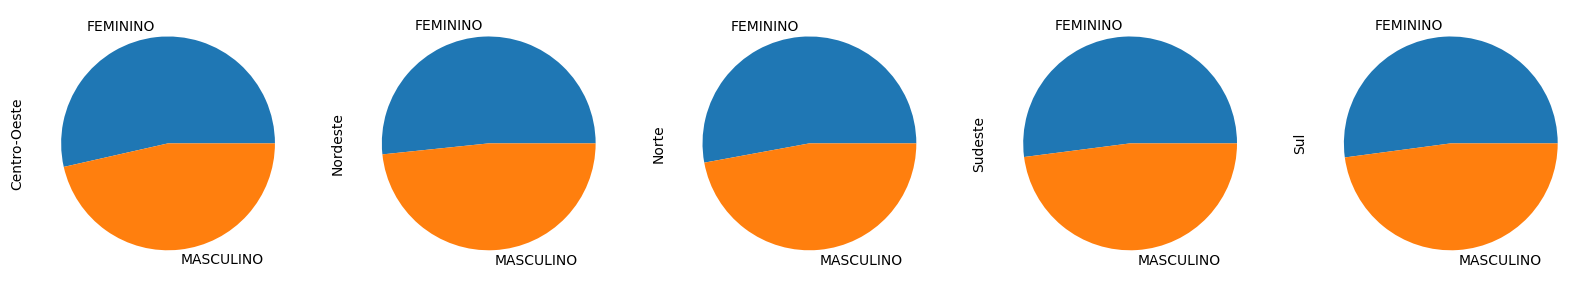

In [6]:
print(dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'sexo'), 'DESCRICAO'].values)
cor = UniversidadePublica.groupby(['NO_REGIAO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum().rename(columns={'QT_ING_FEM':'FEMININO', 'QT_ING_MASC':'MASCULINO'})
cor.T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10))